## Load the FASTA file from the GtRNAdb server

The urllib is used here, but it will be later changed to use keras's resource caching utility.

In [1]:
from keras.utils.data_utils import get_file

fasta_path = get_file('sacCer3-tRNAs.fa', origin='http://gtrnadb.ucsc.edu/genomes/eukaryota/Scere3/sacCer3-tRNAs.fa')

Using TensorFlow backend.


In [2]:
from Bio.SeqIO.FastaIO import SimpleFastaParser

# generator is iterable
sequence_generator = SimpleFastaParser(open(fasta_path))
    
fasta_sequences = [(seq) for (title, seq) in sequence_generator]

In [3]:
# fasta_sequences holds the original sequences from the file
fasta_sequences[:5]

['GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA',
 'GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA',
 'GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA',
 'GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA',
 'GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA']

For now, the sequences are all upper case to make the neural network more effective at determining sequence.

## Vectorizing the sequences

In [4]:
# these should be later changed to include lower case as well
# chars = ['A', 'C', 'G', 'T']
chars = list(set(''.join(fasta_sequences)))

char2index = dict((c, i) for i, c in enumerate(chars))
index2char = dict((i, c) for i, c in enumerate(chars))

In [5]:
# how much we tell the rnn before it has to guess
test_length = 25
step = 3

# list of all the tests, semiredundant
test_sequences = []
next_bases = []

# load in training cases
# for seq in sequences:
for seq in fasta_sequences:
    for i in range(0, len(seq) - test_length, step):
        test_sequences.append(seq[i: i + test_length])
        next_bases.append(seq[i + test_length])

In [6]:
import numpy as np

# turn into vectors
# first dimension - each test case
# second dimension - number of hints to give
# third dimension - boolean representation for chars
X = np.zeros((len(test_sequences), test_length, len(chars)), dtype=np.bool)
y = np.zeros((len(next_bases), len(chars)), dtype=np.bool)

for i, seq in enumerate(test_sequences):
    for t, char in enumerate(seq):
        X[i, t, char2index[char]] = 1
    y[i, char2index[next_bases[i]]] = 1

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

print('Build the single LSTM model...')
model = Sequential()
model.add(LSTM(128, input_shape=(test_length, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

Build the single LSTM model...


In [8]:
from keras.optimizers import RMSprop
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))

In [9]:
def splice_introns(rna_sequence):
    spliced_rna_sequence = ''.join([(nt) for (nt) in rna_sequence if nt.isupper()])
    return spliced_rna_sequence

In [10]:
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna

def transcribe(dna_sequence):
    rna_sequence = Seq(dna_sequence, generic_dna).transcribe()
    return rna_sequence

### Heatmap Generation
This is a very naive approach to analyzing the similarity of the generated sequence to the original sequence. Instead of the viewer manually checking for similarity or generating a number of matched nucleotides, the heatmap allows for visual inspection of the continuity of the sequence.

Long diagonal lines indicates that there is paiwise alignment between the original and generated sequence, however this is not necessarily an unbiased estimator of the effectiveness of this program. The best way to check for the effectiveness would to look at similarities in secondary and tertiary structure rather than primary structure.

The integration of the INFERNAL library aims to analyze secondary structure similarities.

In [12]:
import numpy as np;
import seaborn as sns; sns.set()

def heat_map(dna_original, dna_generated):
    # original on first axis
    heatmap = np.zeros((len(dna_original), len(dna_generated)))

    for i in range(len(dna_original)):
        for j in range(len(dna_generated)):
            if (dna_original[i] == dna_generated[j]):
                if (i == j):
                    heatmap[i, j] = 1
                elif i-1 >= 0 and j-1 >= 0 and heatmap[i-1, j-1] != 0:
                    heatmap[i-1, j-1] = 0.25
                    heatmap[i, j] = 0.25
                else:
                    heatmap[i, j] = 1 / (i - j)**2
                        

    ax = sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
    sns.plt.show()

round 0
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0310     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGCGCGCACGTGTCCTAGCGTGGATCCGGTTCGGGCACGCTCGTGTGCG


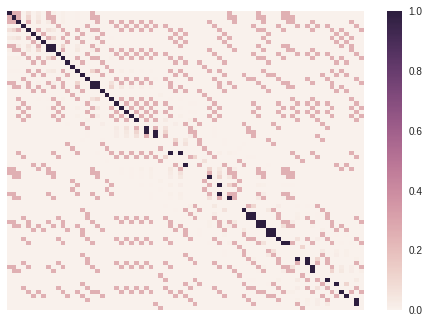

round 1
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0211     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGCGCGCGCGTGTCCCAACCTTTCGAATCCGGTTCGAGTCCCGGGTTGG


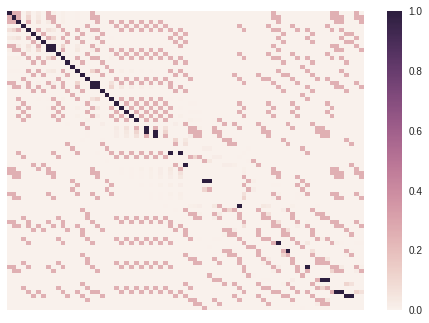

round 2
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0217     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGCGCGCTCGTGTCCCGCGTCCGAATCCGGTTCGCGCATCCCGCAGCGG


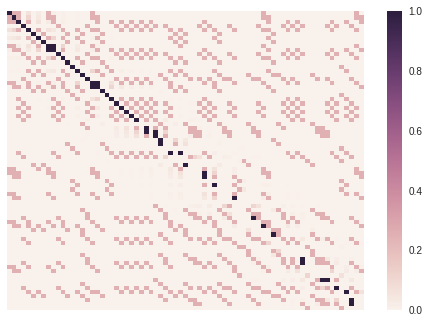

round 3
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0207     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGAGCATCATGTTCTAGAATCCAGGGGGTGTGGTCCGCACTCCCGAATC


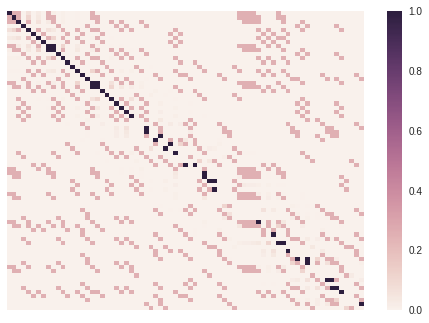

round 4
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0220     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGAGCATCATGTTCTAGAATGTCGGAGCGTCAGACTCTAAAATTTGGAA


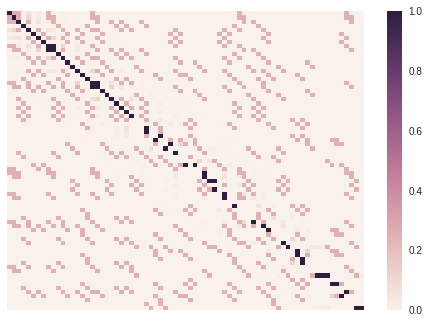

round 5
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0340     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGGGCGCGACTTTCAATCATGAAGAtCCATGGTTCGAATCAGGGAGGCC


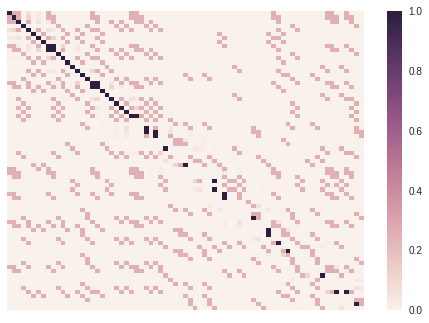

round 6
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0187     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCACGCGCGCGTGTGCGGATCCGGTTCGGGTTCGATTCCCGCACTGTCGC


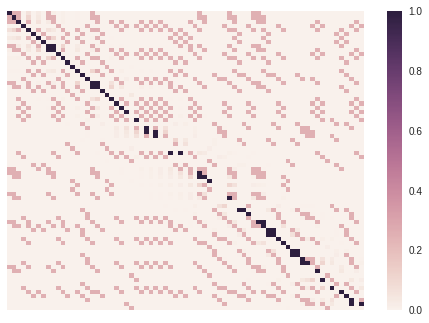

round 7
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0227     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGCGCGCGCGTGTCACTCGTGTTCGAGTTTGAATCTGGCAGTTGGCTCA


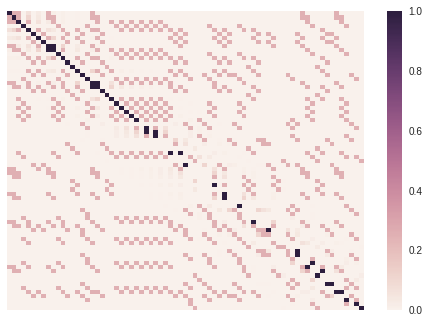

round 8
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0223     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGCAAGTTTCAGTCTCAAATAGGGCGCGAGTCTCACTCTTAAGATTCGA


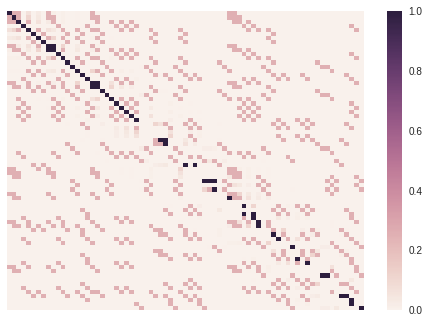

round 9
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0192     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGCGCGCGCGTGTCACTCGTGCGGGTTCGAATCCCGTAGCACACCCATC


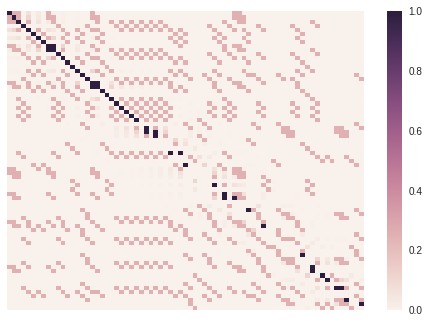

round 10
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0199     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGCGCGTGCGCGTCCGATCCTCGGTTCGAATCCGCGTTCGACCCCCGTG


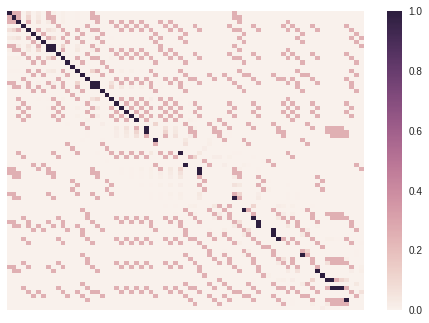

round 11
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0300     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGCACGCTCGCGGCGGCGCACCAGCATCAGGATCTGGTTCGAGTTCGAA


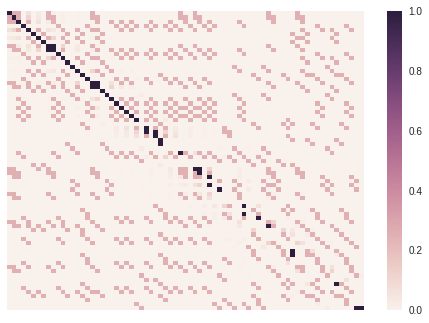

round 12
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0178     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGCACGATCCTGACTCAAGAGTTCGAATCCCTCATCCCCGCTCGAGCAT


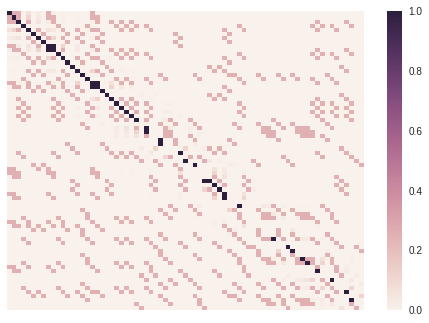

round 13
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0209     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGCGCGCGCGCGTCCGTTCCGCATCCGGAGCGGTCGCGCGTCCGCTCCC


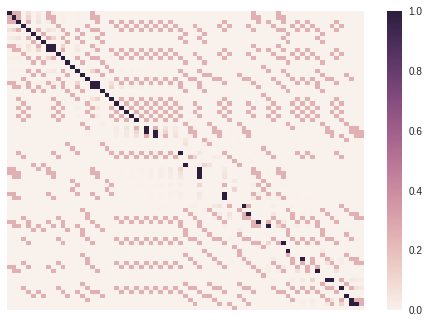

round 14
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0230     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGCGCGCGCGTGTCACACGCTCAAGGATCGGAGTTTGGCTCCCGCAGCA


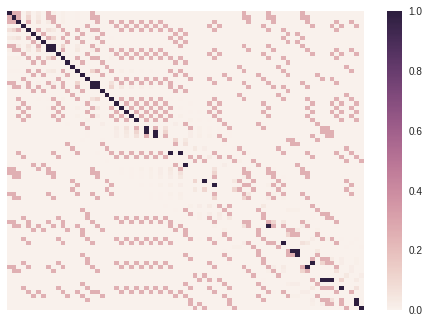

round 15
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0268     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGCGCGCGCGTGTCAGTCGGTTGTGGTGCGAGTGCGCGGGTCCGGTTCC


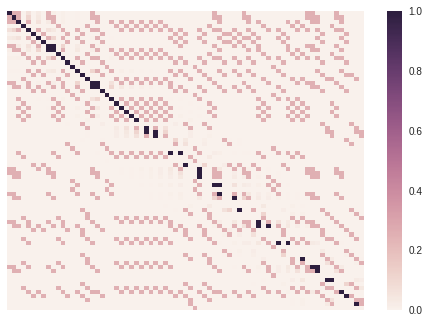

round 16
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0236     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGGGGGCGAGTTTCGTTCTGGTAGCAGCAGCTGTCACATTCTAGAATCC


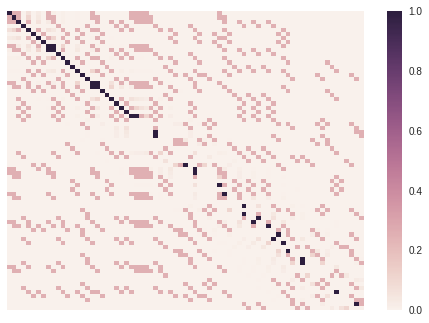

round 17
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0164     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGGGTGCGAGTTCGATTCCAGATTCCAGACCCCGCATCCCGCATGaCGG


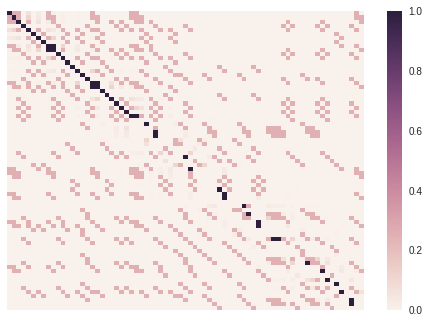

round 18
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0218     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGTTCGAACCTTTCGCTGAGAATCCAGCATTCGCACCCTTCAGAAGGAG


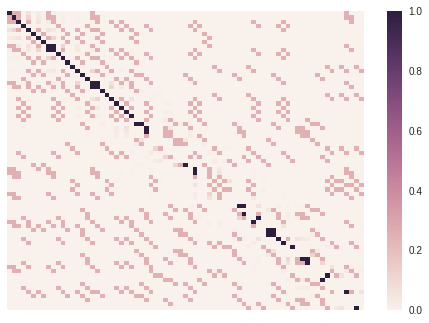

round 19
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0208     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGGGCGCGAGTTCGAATCCAGTTTCCCCCCCGCGGTCGCAGATCCGGAT


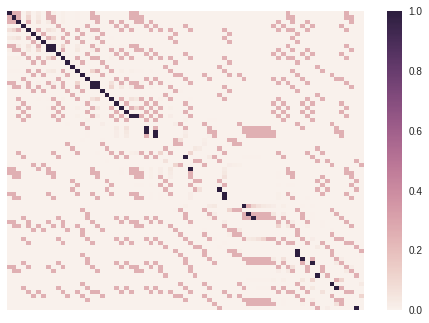

round 20
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0160     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGGGCGCGCGTGTCAGTTCGGGTTCGAGCAGCCGCAGATTCGAGTgTCC


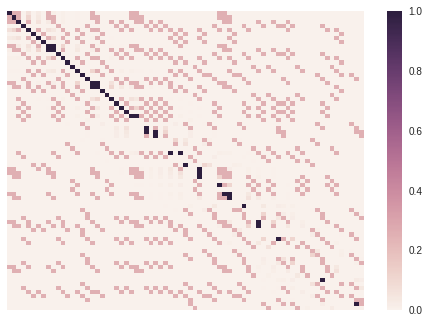

round 21
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0204     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGGGTGCGAGTTCGATTCCAGTTTCGCAGTTCGAATCCCGCAGTTGCAA


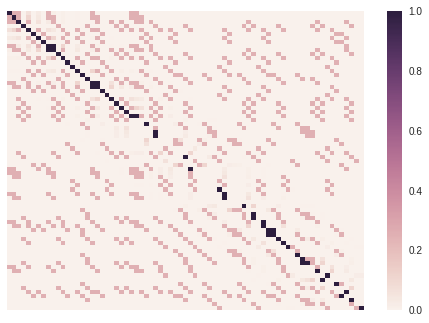

round 22
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0256     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGCGCGCGCGTGTCAGTGCGTGCGTGCAAGTTTGCAGTTTGAGCATCCC


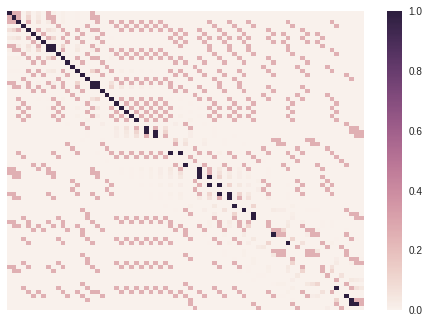

round 23
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0220     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGCGCGTGTCTGTCAGGTCGGGGATCCGTTTCGCTTTCGCATTCGCCCG


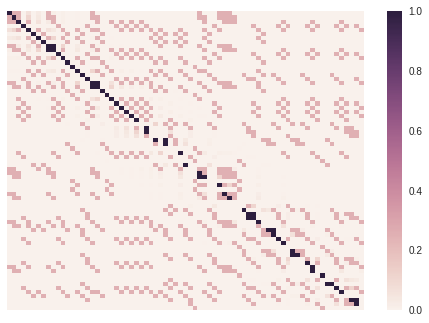

round 24
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0254     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGGGGGTGCGAGTCCGGTTCGAGTGTGGGCGTGCGAGTCTGGGTTCGAG


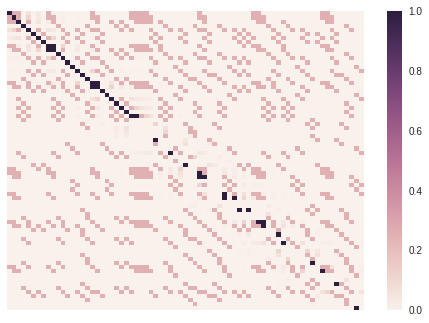

round 25
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0160     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGGGGACGATCATCAGTTTTAAAATGCAGGTTCGAGTTCGAGTCTCACA


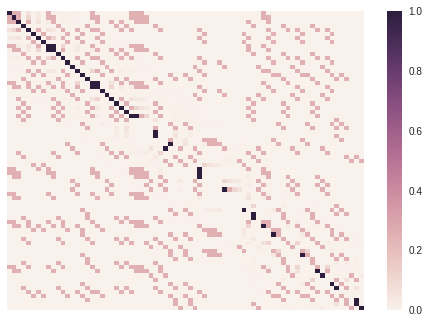

round 26
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0268     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGCGCGCGCGCGTCCGTCGTTCGAATCCGGTTTTCGCAGTTTTGCAGCG


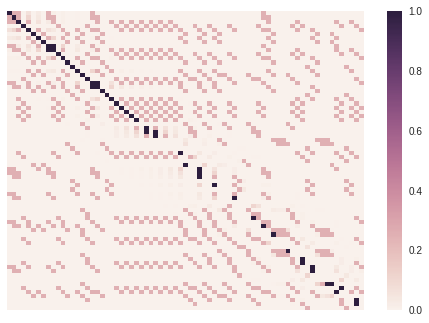

round 27
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0241     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGTGCGCGCGTGTCAGTCTAGAATCCCGTTTCGCACTCCCGCACGCCCG


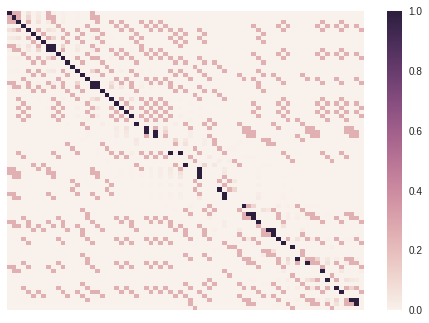

round 28
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0299     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGCGCGCGCGCGTCAGCAGTTTCGGATCTGGTGTGCGATTCCAGTTTCA


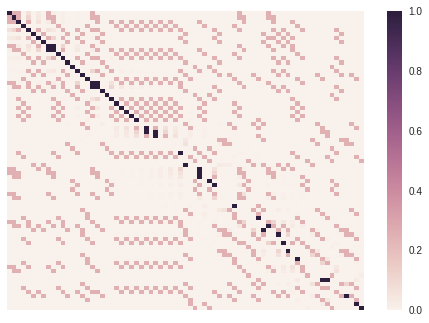

round 29
Epoch 1/1
5109/5109 [==============================] - 3s - loss: 0.0289     
GGGCGTGTGGCGTAGTCGGTAGCGC
GGGCGTGTGGCGTAGTCGGTAGCGCGCTCCCTTAGCATGGGAGAGGtCTCCGGTTCGATTCCGGACTCGTCCA
GGGCGTGTGGCGTAGTCGGTAGCGCGCGCGCGCGCGTCAGAGCGTGAGTTTGAATCTGGTTCGAAGAttcgtc


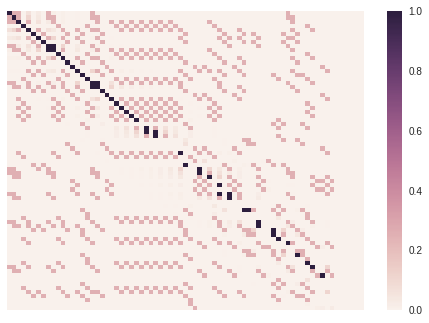

In [26]:
sto_sequences = []
from Bio.SeqRecord import SeqRecord

for i in range(30):
    print('round %i' % i)
    model.fit(X, y, batch_size=128, epochs=1)

    pred = model.predict(X[0:1])
    pred_index = np.argmax(pred)
    pred_char = index2char[pred_index]

    generated = ''
    sentence = fasta_sequences[0][0: test_length]
    generated += sentence

    print(generated)

    for j in range(73 - test_length):
        x = np.zeros((1, test_length, len(chars)), dtype=np.bool)
        for t, char in enumerate(sentence):
            x[0, t, char2index[char]] = 1
        pred = model.predict(x)
        pred_index = np.argmax(pred)
        pred_char = index2char[pred_index]

        generated += pred_char
        sentence = sentence[1:] + pred_char

    # only testing on the first one
    dna_original = fasta_sequences[0]
    print(dna_original)
    print(generated, flush=True)
    
    rna_sequence = transcribe(generated)

    record = SeqRecord(rna_sequence, id=str(i))
    
    sto_sequences.append(record)

    heat_map(dna_original, generated)

In [27]:
from Bio import SeqIO
with open('example.sto', 'w') as output_handle:
    SeqIO.write(sto_sequences, output_handle, 'stockholm')